# Anomaly Detection

## 1- River Real-Time Isolation Forest

In [ ]:
# 1. Setup
%pip install -e .. -q
%load_ext autoreload
%autoreload 2

In [1]:
# 2. Load default config
from pathlib import Path

import pandas as pd

from metro_disruptions_intelligence.detect import StreamingIForestDetector
from metro_disruptions_intelligence.processed_reader import compose_path

project_root = Path.cwd().parent

config_path = project_root / "configs" / "iforest_default.yaml"

**Note:** `StreamingIForestDetector` uses a default `subsample_size` of 256.
Running it on fewer observations (like the small example below) will
yield zero anomaly scores. For small samples you can pass a custom
configuration:
```python
from metro_disruptions_intelligence.detect import IForestConfig
det = StreamingIForestDetector(IForestConfig(subsample_size=50))
```

In [2]:
# 3. Choose processed features root
project_root = Path.cwd().parent
processed_root = project_root / "data" / "stations_features_time_series"

In [3]:
print(processed_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


The features should be stored in `data/stations_features_time_series` as described in the documentation.
If this directory is empty you must generate the Parquet files first.

### Training initial detector in 2 weeks data

In [ ]:
# 4a. Train detector on stored feature files and save model
from datetime import datetime, timedelta

train_start = datetime(2025, 3, 6, 16, 50)
train_end = train_start + timedelta(days=7)
det = StreamingIForestDetector(config_path)  # noqa: F821
for ts in range(int(train_start.timestamp()), int(train_end.timestamp()), 60):
    p = compose_path(ts, processed_root, "stations_feats")
    if not p.exists():
        continue
    df = pd.read_parquet(p)
    det.score_and_update(df)
det.save("iforest_model.pkl")

### Trial SHAP in 2 weeks data

In [ ]:
# 4. Compute anomaly scores for the first two weeks
import json
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

start = train_end
end = train_end + timedelta(days=14)  # compute next 2 weeks
# end = datetime(2025, 5, 22, 10, 56)  # use this for full dataset
rows = []
det = StreamingIForestDetector(config_path)  # noqa: F821
for ts in range(int(start.timestamp()), int(end.timestamp()), 60):
    f = compose_path(ts, processed_root, "stations_feats")
    if not f.exists():
        continue
    df = pd.read_parquet(f)
    out = det.score_and_update(df, explain=True)
    rows.append(out)
scores = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

In [30]:
# 1) create a UTC-aware datetime column
scores["dt_utc"] = pd.to_datetime(scores["ts"], unit="s", utc=True)

# 2a) convert to Sydney wall-clock time
scores["dt_sydney"] = scores["dt_utc"].dt.tz_convert("Australia/Sydney")

# 2b) (optionally) convert to London wall-clock time
scores["dt_london"] = scores["dt_utc"].dt.tz_convert("Europe/London")

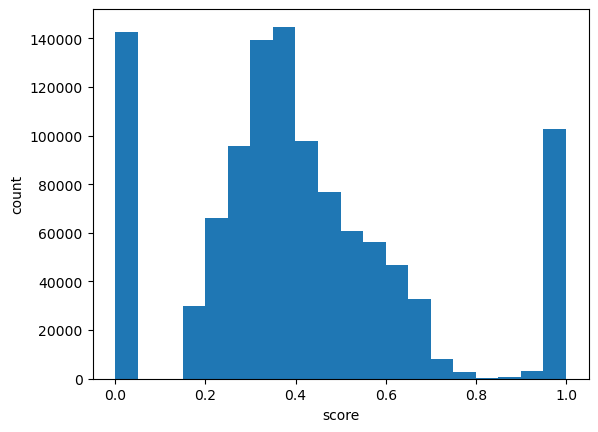

In [31]:
# 5. Histogram of anomaly_score
plt.hist(scores["anomaly_score"], bins=20)
plt.xlabel("score")
plt.ylabel("count");

In [32]:
# 6. Top-10 anomalies with SHAP explanations
top10 = scores.nlargest(10, "anomaly_score").copy()
top10["shap_top3"] = top10["shap_top3_json"].apply(json.loads)
top10[["ts", "stop_id", "anomaly_score", "shap_top3"]]

,ts,stop_id,anomaly_score,shap_top3
645228,1742589000,2000464,0.999270,"[[headway_t, 0.0002994899853443478], [delay_ar..."
643033,1742586600,2065163,0.999221,"[[headway_t, 0.0004758378114313455], [delay_ar..."
643583,1742587200,2065163,0.999221,"[[headway_t, 0.0004758378114313455], [delay_ar..."
645233,1742589000,2065163,0.999221,"[[headway_t, 0.0004758378114313455], [delay_ar..."
647983,1742592000,2065163,0.999221,"[[headway_t, 0.0004758378114313455], [delay_ar..."
649633,1742593800,2065163,0.999221,"[[headway_t, 0.0004758378114313455], [delay_ar..."
248123,1742155500,2000463,0.999214,"[[headway_p90_60, 0.0004026126038104705], [hub..."
248563,1742155980,2000463,0.999214,"[[headway_p90_60, 0.0004026126038104705], [hub..."
249003,1742156460,2000463,0.999214,"[[headway_p90_60, 0.0004026126038104705], [hub..."
249663,1742157180,2000463,0.999214,"[[headway_p90_60, 0.0004026126038104705], [hub..."


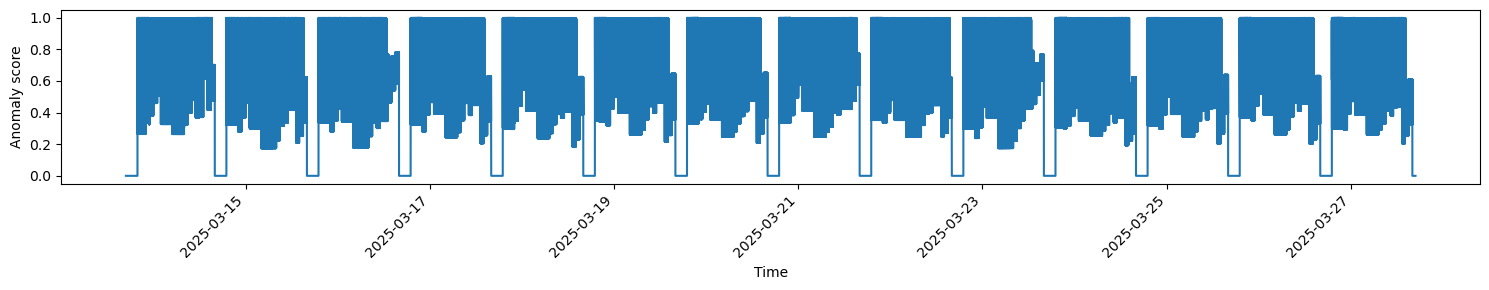

In [33]:
# 7. Plot anomaly_score over time

# convert timestamps → datetimes
scores["dt"] = pd.to_datetime(scores["ts"], unit="s")

# sort & index
s = scores.sort_values("dt").set_index("dt")["anomaly_score"]

# make a long, skinny figure
plt.figure(figsize=(15, 3))
s.plot()
plt.xlabel("Time")
plt.ylabel("Anomaly score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# 8. Tune hyper-parameters via CLI
# The command below tunes n_trees, height, subsample_size, window_size, and threshold_quantile.
# Adjust the start and end dates to match your data.
# !poetry run mdi tune-iforest \
# +        --processed-root data/stations_features_time_series \
# +        --start 2025-03-06T16:50:00Z \
# +        --end 2025-05-22T10:56:00Z
# print(Path("iforest_best.yaml").read_text())

In [ ]:
# make sure your JSON string column is a plain str
scores["shap_top3_json"] = scores["shap_top3_json"].astype(str)

# if you created a Python list column (e.g. shap_list), drop it:
to_write = scores.drop(columns=["shap_list"], errors="ignore")

# now safely write everything else
to_write.to_parquet(
    path=project_root
    / "data"
    / "working_data"
    / "anomaly_detection"
    / "scores_with_SHAP_trial.parquet",
    engine="pyarrow",
    compression="snappy",
    index=False,
)

In [38]:
scores_test = pd.read_parquet(
    r"C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\working_data\anomaly_detection\scores_with_SHAP_trial.parquet"
)

In [46]:
scores_stop2000465 = scores_test[scores_test["stop_id"] == "2000465"]
scores_stop2000465.head(5)

,ts,stop_id,direction_id,anomaly_score,anomaly_flag,shap_top3_json,dt,dt_utc,dt_sydney,dt_london
0,1741884600,2000465,0,0.0,0,"[[""arrival_delay_t"", 0], [""departure_delay_t"",...",2025-03-13 16:50:00,2025-03-13 16:50:00+00:00,2025-03-14 03:50:00+11:00,2025-03-13 16:50:00+00:00
25,1741884600,2000465,1,0.0,0,"[[""arrival_delay_t"", 0], [""departure_delay_t"",...",2025-03-13 16:50:00,2025-03-13 16:50:00+00:00,2025-03-14 03:50:00+11:00,2025-03-13 16:50:00+00:00
55,1741884660,2000465,0,0.0,0,"[[""arrival_delay_t"", 0], [""departure_delay_t"",...",2025-03-13 16:51:00,2025-03-13 16:51:00+00:00,2025-03-14 03:51:00+11:00,2025-03-13 16:51:00+00:00
80,1741884660,2000465,1,0.0,0,"[[""arrival_delay_t"", 0], [""departure_delay_t"",...",2025-03-13 16:51:00,2025-03-13 16:51:00+00:00,2025-03-14 03:51:00+11:00,2025-03-13 16:51:00+00:00
110,1741884720,2000465,0,0.0,0,"[[""arrival_delay_t"", 0], [""departure_delay_t"",...",2025-03-13 16:52:00,2025-03-13 16:52:00+00:00,2025-03-14 03:52:00+11:00,2025-03-13 16:52:00+00:00


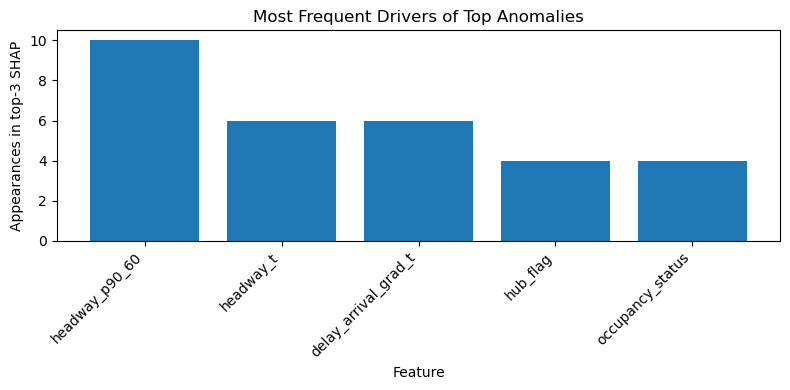

In [40]:
from collections import Counter

# 1) Flatten your top-3 SHAP lists (assuming you've already json-loaded them):
all_features = [feat for shap_list in top10["shap_top3"] for feat, _ in shap_list]

# 2) Count frequencies
feature_counts = Counter(all_features)

# 3) Build a DataFrame from the list of (feature, count) tuples
feat_df = pd.DataFrame(
    list(feature_counts.items()),  # <-- wrap in list()
    columns=["feature", "count"],
).sort_values("count", ascending=False)

# 4) Plot
plt.figure(figsize=(8, 4))
plt.bar(feat_df["feature"], feat_df["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Appearances in top-3 SHAP")
plt.title("Most Frequent Drivers of Top Anomalies")
plt.tight_layout()
plt.show()

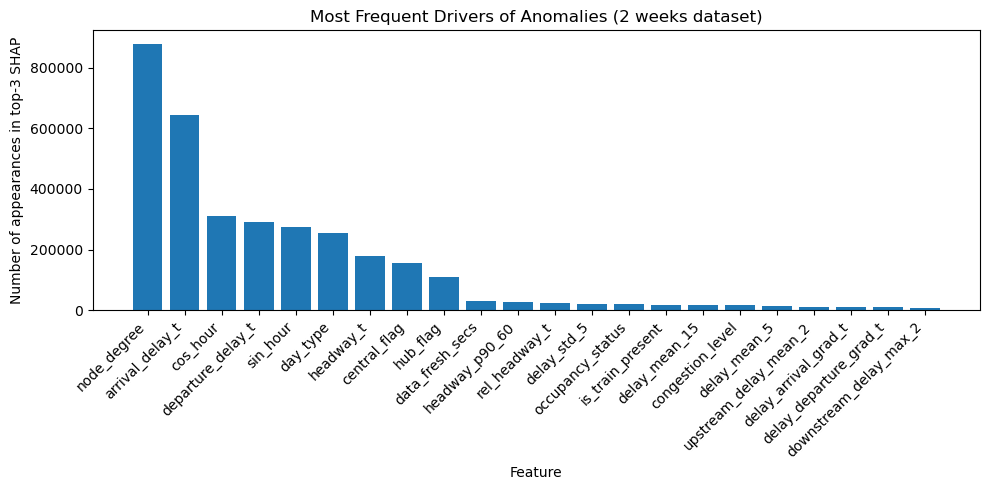

In [ ]:
# 1) Parse the JSON strings into actual Python lists
scores["shap_list"] = scores["shap_top3_json"].apply(json.loads)

# 2) Flatten all feature names from each row’s top-3 SHAP tuples
all_features = [feat for shap_list in scores["shap_list"] for feat, _ in shap_list]

# 3) Count how often each feature appears
feature_counts = Counter(all_features)

# 4) Turn into a sorted DataFrame
feat_df = pd.DataFrame(list(feature_counts.items()), columns=["feature", "count"]).sort_values(
    "count", ascending=False
)

# 5) Plot
plt.figure(figsize=(10, 5))
plt.bar(feat_df["feature"], feat_df["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Number of appearances in top-3 SHAP")
plt.title("Most Frequent Drivers of Anomalies (2 weeks dataset)")
plt.tight_layout()
plt.show()

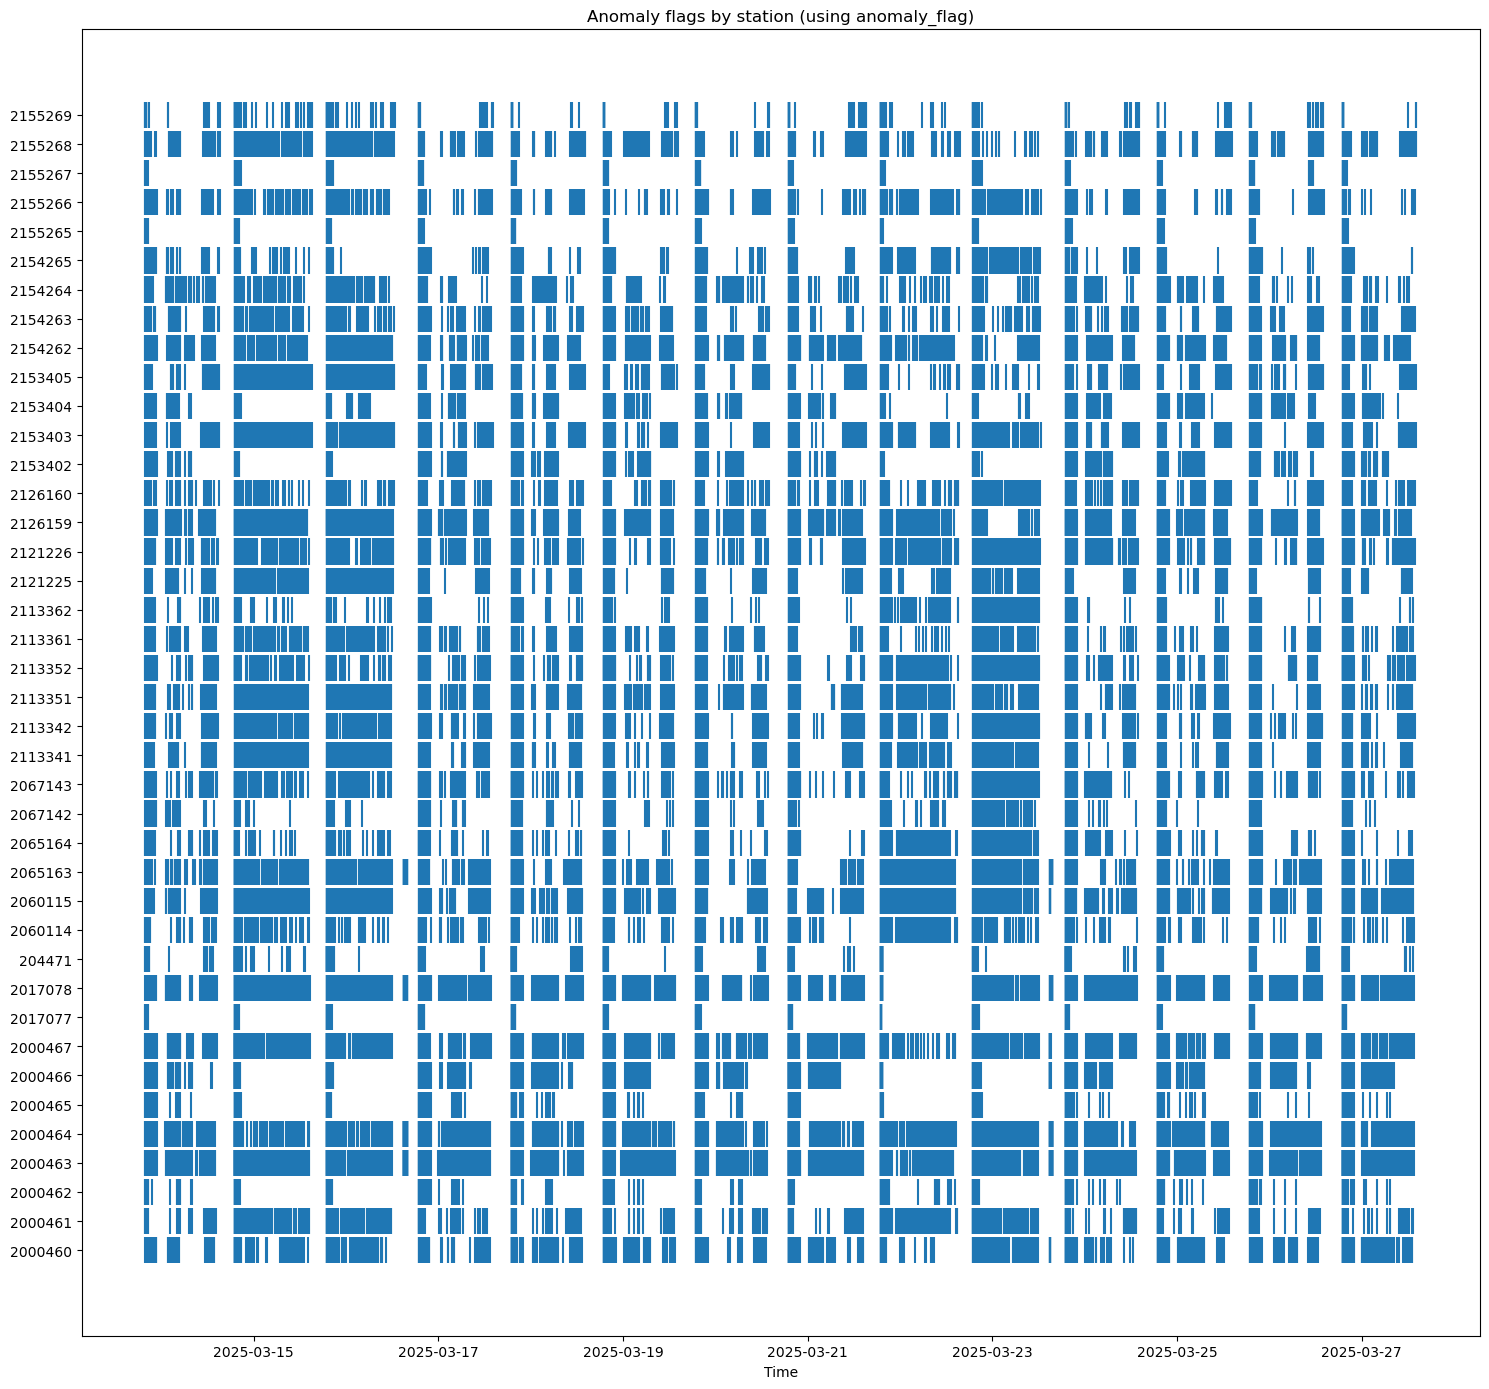

In [42]:
# ──────────────────────────────────────────────────────────────
# 1. Compact visualisation – one dot per flagged anomaly per station
# ---------------------------------------------------------------------------
# Filter only the flagged rows
anom = scores[scores["anomaly_flag"] == 1].copy()

# Convert ts → datetime once
anom["dt"] = pd.to_datetime(anom["ts"], unit="s")

# Sort station IDs so the plot is stable
unique_stops = sorted(anom["stop_id"].unique())

fig, ax = plt.subplots(figsize=(15, 0.35 * len(unique_stops)))  # height ∝ #stops
for i, stop in enumerate(unique_stops):
    times = anom.loc[anom["stop_id"] == stop, "dt"]
    ax.eventplot(times, lineoffsets=i, linelengths=0.9, colors="tab:blue")

ax.set_yticks(range(len(unique_stops)))
ax.set_yticklabels(unique_stops)
ax.set_xlabel("Time")
ax.set_title("Anomaly flags by station (using anomaly_flag)")
plt.tight_layout()
plt.show()

In [43]:
# ──────────────────────────────────────────────────────────────
# 2. Stations with the most anomaly flags
# ---------------------------------------------------------------------------
station_counts = anom.groupby("stop_id").size().sort_values(ascending=False).rename("n_anomalies")
print("Top 10 stations by anomaly_flag count:")
print(station_counts.head(10))

Top 10 stations by anomaly_flag count:
stop_id
2000463    2545
2000464    2246
2017078    1794
2000467    1610
2126159    1480
2065163    1299
2060115    1296
2154262    1265
2000466    1212
2113351    1094
Name: n_anomalies, dtype: int64


,total_anoms,total_snaps,rate
stop_id,,,
2017078,1794,20132,0.089112
2065163,1299,20132,0.064524
2060115,1296,20132,0.064375
2000463,2545,40264,0.063208
2154262,1265,20132,0.062835
2000464,2246,40264,0.055782
2113351,1094,20132,0.054341
2000460,1015,20132,0.050417
2121226,1008,20132,0.050070


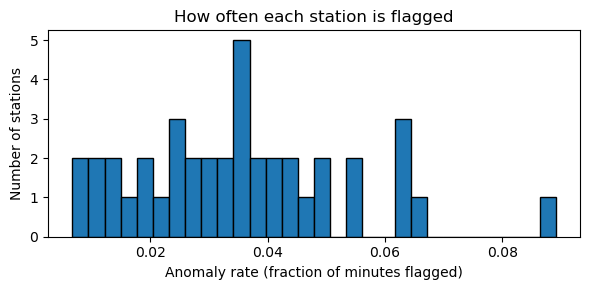

In [47]:
# ─────────────────────────────────────────────────────────────
# A) Summarize anomaly counts + rates per station
# ─────────────────────────────────────────────────────────────
stats = scores.groupby("stop_id")["anomaly_flag"].agg(total_anoms="sum", total_snaps="count")
stats["rate"] = stats["total_anoms"] / stats["total_snaps"]

# sort by rate desc, or by total_anoms if you prefer
stats = stats.sort_values("rate", ascending=False)
display(stats.head(10))

# Also look at the distribution of rates
plt.figure(figsize=(6, 3))
plt.hist(stats["rate"], bins=30, edgecolor="k")
plt.xlabel("Anomaly rate (fraction of minutes flagged)")
plt.ylabel("Number of stations")
plt.title("How often each station is flagged")
plt.tight_layout()
plt.show()

In [48]:
# ─────────────────────────────────────────────────────────────
# B) If the rates look too high, tighten your cut-off:
#     e.g. only consider anomaly_score ≥ 0.99
# ─────────────────────────────────────────────────────────────
scores["high_conf_anom"] = scores["anomaly_score"] >= 0.99

# Recompute stats for this stricter definition
high_stats = scores.groupby("stop_id")["high_conf_anom"].agg(n_high="sum", total="count")
high_stats["rate_high"] = high_stats["n_high"] / high_stats["total"]
high_stats = high_stats.sort_values("rate_high", ascending=False)
display(high_stats.head(10))

,n_high,total,rate_high
stop_id,,,
2060115,2479,20132,0.123137
2153405,2453,20132,0.121846
2153403,2430,20132,0.120703
2017078,2427,20132,0.120554
2155268,2424,20132,0.120405
2121226,2422,20132,0.120306
2154262,2420,20132,0.120207
2154263,2414,20132,0.119909
2113342,2392,20132,0.118816


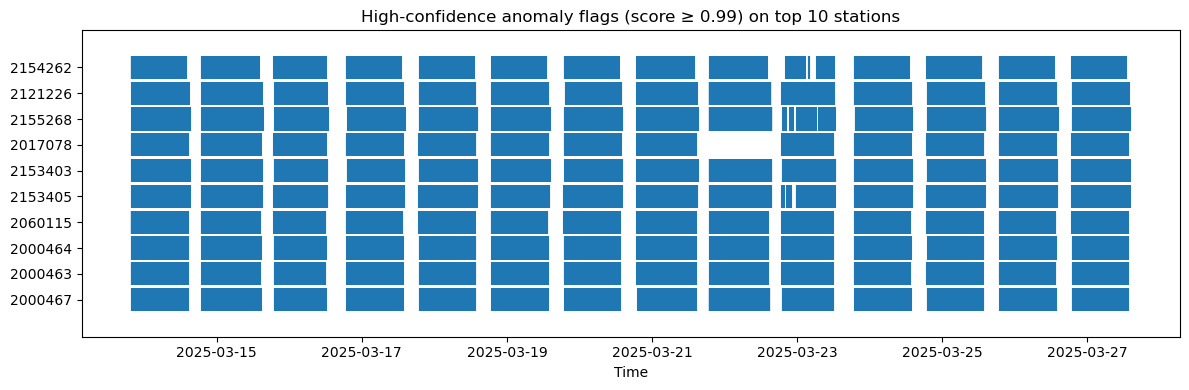

In [49]:
# ─────────────────────────────────────────────────────────────
# C) Eventplot of just the high-confidence anomalies
# ─────────────────────────────────────────────────────────────
anom = scores[scores["high_conf_anom"]].copy()
anom["dt"] = pd.to_datetime(anom["ts"], unit="s")

# pick top 10 stations by # of these high-conf anomalies
top10 = high_stats.nlargest(10, "n_high").index.tolist()
subset = anom[anom["stop_id"].isin(top10)]

fig, ax = plt.subplots(figsize=(12, 4))
for i, stop in enumerate(top10):
    times = subset.loc[subset["stop_id"] == stop, "dt"]
    ax.eventplot(times, lineoffsets=i, linelengths=0.9)

ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10)
ax.set_xlabel("Time")
ax.set_title("High-confidence anomaly flags (score ≥ 0.99) on top 10 stations")
plt.tight_layout()
plt.show()

In [44]:
# ──────────────────────────────────────────────────────────────
# 3. Summary table: per-station count plus the exact snapshots
# ---------------------------------------------------------------------------
summary = anom.groupby("stop_id").agg(
    n_anomalies=("anomaly_flag", "size"), snapshots_ts=("ts", list)
)

# Optionally add human-readable timestamps
summary["snapshots_dt"] = summary["snapshots_ts"].apply(
    lambda lst: [pd.to_datetime(ts, unit="s") for ts in lst]
)

# Display the first few rows
display(summary.head())

,n_anomalies,snapshots_ts,snapshots_dt
stop_id,,,
2000460,1015,"[1741895520, 1741895580, 1741895640, 174189570...","[2025-03-13 19:52:00, 2025-03-13 19:53:00, 202..."
2000461,853,"[1741895520, 1741895520, 1741895580, 174189558...","[2025-03-13 19:52:00, 2025-03-13 19:52:00, 202..."
2000462,390,"[1741895520, 1741895520, 1741895580, 174189558...","[2025-03-13 19:52:00, 2025-03-13 19:52:00, 202..."
2000463,2545,"[1741895520, 1741895520, 1741895580, 174189558...","[2025-03-13 19:52:00, 2025-03-13 19:52:00, 202..."
2000464,2246,"[1741895520, 1741895520, 1741895580, 174189558...","[2025-03-13 19:52:00, 2025-03-13 19:52:00, 202..."


### Final River RT Isolation Forest: No SHAP values are saved due to time constraints

In [6]:
print(processed_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [14]:
# 7. Score dataset with sliding window
from metro_disruptions_intelligence.processed_reader import discover_all_snapshot_minutes
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

station_subset = [
    2155269,
    2155267,
    2155265,
    2153402,
    2153404,
    2154264,
    2154262,
    2126159,
    2121225,
    2113351,
    2113341,
    2113361,
    2067142,
    2065163,
    2060115,
    2000460,
    2000463,
    2000464,
    2000467,
    2017078,
    204471,
]
all_minutes = discover_all_snapshot_minutes(processed_root)
train_start = datetime(2025, 3, 6, 16, 50)
train_end = train_start + timedelta(days=30)
final_dt = datetime(2025, 5, 22, 10, 56)
train_minutes = [ts for ts in all_minutes if train_start.timestamp() <= ts < train_end.timestamp()]
score_minutes = [ts for ts in all_minutes if train_end.timestamp() <= ts <= final_dt.timestamp()]

det_full = StreamingIForestDetector(
    config_path, station_ids=station_subset, drop_features=["data_fresh_secs", "dwell_delta_t"]
)
# Train detector on the first month of data
for ts in train_minutes:
    f = compose_path(ts = ts, root=processed_root, feed="stations_feats")
    if not f.exists():
        continue
    df = pd.read_parquet(f)
    det_full.score_and_update(df, explain=False)

# Score remaining minutes
rows = []
for ts in score_minutes:
    f = compose_path(ts = ts, root=processed_root, feed="stations_feats")
    if not f.exists():
        continue
    df = pd.read_parquet(f)
    out = det_full.score_and_update(df, explain=False)
    if not out.empty:
        rows.append(out)

scores_full = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
det_full.save("iforest_model_final.pkl")

### Evaluation against ground truth

In [10]:
# 8. Evaluate against ground truth
from metro_disruptions_intelligence.processed_reader import load_rt_dataset
from metro_disruptions_intelligence.evaluation import build_events, evaluate_scores

alerts_root = project_root / "data" / "processed_final" / "rt"
alerts_df = load_rt_dataset(alerts_root, feeds=["alerts"])
events_all = build_events(alerts_df)
metrics_all = evaluate_scores(scores_full, events_all)

# Exclude maintenance and construction
events_disrupt = events_all[~events_all["cause"].isin([9, 10])]
maintenance_days = pd.to_datetime(
    alerts_df[alerts_df["cause"].isin([9, 10])]["snapshot_timestamp"], unit="s", utc=True
).dt.date.unique()

scores_full["ts_dt"] = pd.to_datetime(scores_full["ts"], unit="s", utc=True)
scores_nm = scores_full[~scores_full["ts_dt"].dt.date.isin(maintenance_days)]
metrics_no_maint = evaluate_scores(scores_nm, events_disrupt)

KeyboardInterrupt: 

## 2- Isolation Forest Trained Offline

### Evaluation against ground truth

## 3- Isolation Forest trained with labels - Generalization

### Evaluation against ground truth